In [ ]:
#default_exp data.augment

# Data augmentation

> Transforms that have different behavior for different parts of their input

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *

In [ ]:
source = untar_data(URLs.MNIST_TINY)
items = get_image_files(source)
splits = GrandparentSplitter()(items)

tfm = TfmOver.piped([[Imagify(cmap="Greys",figsize=(1,1)),ImageToByteTensor()], [parent_label, Categorize()]])
mnist = DataSource(items, tfm, filts=splits)

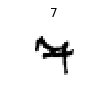

In [ ]:
mnist.train.show_at(0)

In [ ]:
# Also adds `p` param (defaults to 1)
AugRotate = make_augment(rotate, degrees=RandFloat(0,90))

In [ ]:
# Creates Image.rotate
@patch
def rotate(x:Image, degrees):
    return ...